# **Step 1: Install Required Libraries**

In [ ]:
!pip install swifter --quiet
!pip install nlpaug --quiet
!pip install nltk --quiet


# **Step 2: Import Libraries**

In [ ]:
import re
import string
import os
import pandas as pd
import numpy as np
import swifter
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import nlpaug.augmenter.word as naw
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
import seaborn as sns

# **Step 3: Download NLTK Resources**

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/AIDL MASTER/AIDL_02/Final project/ForTheProfessor/"


Mounted at /content/drive


# **Step 4: Load the Dataset**

In [ ]:
data = pd.read_csv(project_path + "discharge_balanced.csv")
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   subject_id     30000 non-null  int64 
 1   hadm_id        30000 non-null  int64 
 2   text           30000 non-null  object
 3   mortality_30d  30000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 937.6+ KB


# **Step 5: Apply Data Augmentation**

In [ ]:
aug = naw.SynonymAug(aug_src='wordnet', aug_max=3)
augmented_texts = data['text'].sample(frac=0.2, random_state=42).apply(lambda x: aug.augment(x))
data.loc[augmented_texts.index, 'text'] = augmented_texts.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)


# **Step 6: Clean Text**

In [ ]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

data['clean_text'] = data['text'].swifter.apply(clean_text)


Pandas Apply:   0%|          | 0/30000 [00:00<?, ?it/s]

# **Step 7: Tokenization and Padding**

In [ ]:
MAX_WORDS = 20000
MAX_LEN = 300

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(data['clean_text'])
sequences = tokenizer.texts_to_sequences(data['clean_text'])

X = pad_sequences(sequences, maxlen=MAX_LEN)
y = data['mortality_30d'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Callbacks for Model Saving & Early Stopping**


In [ ]:
# Common callbacks factory so all models save their own best weights (Keras 3-safe)
def make_callbacks(tag: str, monitor: str = "val_loss"):
    # Keras 3: when save_weights_only=True, must end with ".weights.h5"
    ckpt_path = f"best_model_{tag}.weights.h5"
    early = EarlyStopping(
        monitor=monitor,
        patience=5,
        restore_best_weights=True
    )
    ckpt = ModelCheckpoint(
        filepath=ckpt_path,
        monitor=monitor,
        mode="min",
        save_best_only=True,
        save_weights_only=True
    )
    return early, ckpt, ckpt_path


# **Step 8: LSTM Model with Trainable Custom Embeddings**

In [ ]:
# Step 8: LSTM Model with Trainable Custom Embeddings (with callbacks & best-weight restore)
model_custom = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN, trainable=True),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_custom.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_c, ckpt_c, ckpt_path_c = make_callbacks(tag="custom_lstm")

history_custom = model_custom.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_c, ckpt_c],
    verbose=1
)

# ensure best weights (in case best epoch wasn't the last)
model_custom.load_weights(ckpt_path_c)


Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 105s 671ms/step - accuracy: 0.7739 - loss: 0.4848 - val_accuracy: 0.8542 - val_loss: 0.3350
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 138s 644ms/step - accuracy: 0.8780 - loss: 0.3041 - val_accuracy: 0.8531 - val_loss: 0.3758
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 144s 659ms/step - accuracy: 0.8907 - loss: 0.2799 - val_accuracy: 0.8462 - val_loss: 0.3445
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 101s 673ms/step - accuracy: 0.9063 - loss: 0.2405 - val_accuracy: 0.8587 - val_loss: 0.3305
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 675ms/step - accuracy: 0.9188 - loss: 0.2218 - val_accuracy: 0.8615 - val_loss: 0.3698
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 140s 658ms/step - accuracy: 0.9212 - loss: 0.2025 - val_accuracy: 0.8592 - val_loss: 0.3930
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 102s 679ms/step - accuracy: 0.9230 - loss: 0.1973 - val_accuracy: 0.8512 - val_loss: 0.3823
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 672ms/step - accuracy: 0.9440 -

# **Step 8b: BiLSTM Model with Trainable Custom Embeddings**


In [ ]:
# Step 8b: Second custom model (BiLSTM) to increase model diversity
model_bilstm = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN, trainable=True),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_bi, ckpt_bi, ckpt_path_bi = make_callbacks(tag="custom_bilstm")

history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_bi, ckpt_bi],
    verbose=1
)

model_bilstm.load_weights(ckpt_path_bi)


Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.7688 - loss: 0.4864 - val_accuracy: 0.8540 - val_loss: 0.3216
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.8827 - loss: 0.2736 - val_accuracy: 0.8673 - val_loss: 0.3030
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.9164 - loss: 0.2114 - val_accuracy: 0.8637 - val_loss: 0.3350
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9415 - loss: 0.1549 - val_accuracy: 0.8446 - val_loss: 0.3757
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9598 - loss: 0.1100 - val_accuracy: 0.8440 - val_loss: 0.4188
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9767 - loss: 0.0697 - val_accuracy: 0.8367 - val_loss: 0.4863
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9768 - loss: 0.0650 - val_accuracy: 0.8444 - val_loss: 0.6075


# **Step 9: Plot Custom LSTM Accuracy & Loss**

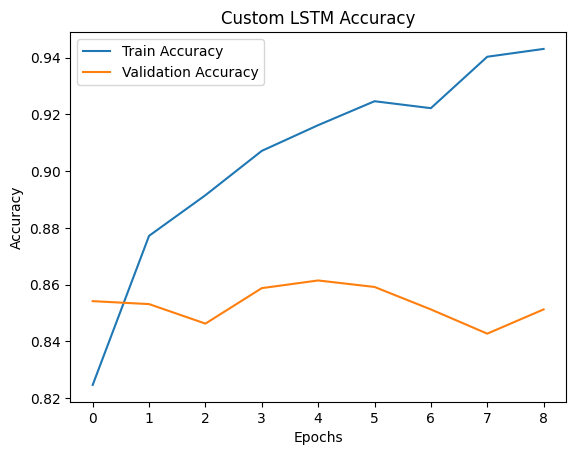

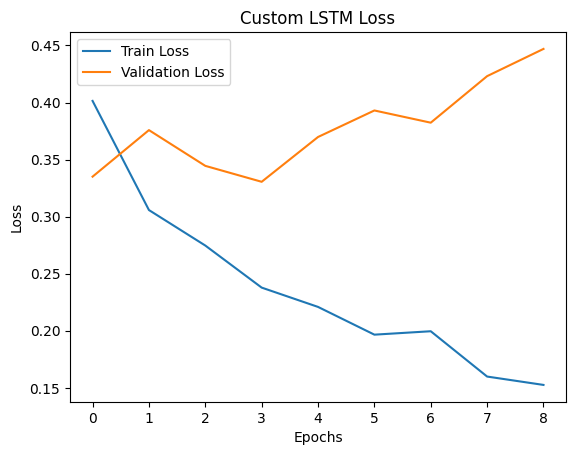

In [ ]:
# Accuracy
plt.plot(history_custom.history['accuracy'], label='Train Accuracy')
plt.plot(history_custom.history['val_accuracy'], label='Validation Accuracy')
plt.title('Custom LSTM Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history_custom.history['loss'], label='Train Loss')
plt.plot(history_custom.history['val_loss'], label='Validation Loss')
plt.title('Custom LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **Step 10: Evaluate & Report (Custom)**

188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step
Confusion Matrix:
[[2684  359]
 [ 486 2471]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      3043
           1       0.87      0.84      0.85      2957

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



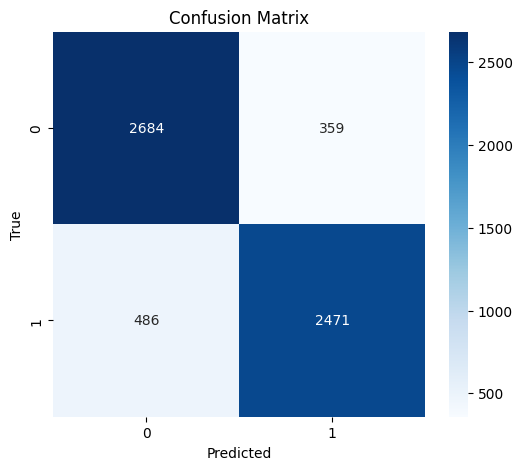

In [ ]:
y_pred_custom = (model_custom.predict(X_test) > 0.5).astype("int32")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Evaluate & Report (BiLSTM Custom)
y_pred_bilstm = (model_bilstm.predict(X_test) > 0.5).astype("int32")
print(" BiLSTM Custom:")
print(classification_report(y_test, y_pred_bilstm))
print(confusion_matrix(y_test, y_pred_bilstm))


188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step
 BiLSTM Custom:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      3043
           1       0.89      0.84      0.86      2957

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000

[[2736  307]
 [ 471 2486]]


# **Step 11: LSTM with GloVe (Frozen Embeddings)**

In [ ]:
embedding_index = {}
with open('/content/drive/MyDrive/AIDL MASTER/AIDL_02/Final project/glove.6B/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))
for word, i in word_index.items():
    if i < MAX_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


# **Step 12: LSTM Model with GloVe Embeddings**

In [ ]:
# Step 12: LSTM Model with GloVe Embeddings (Frozen) + callbacks & best-weight restore
model_glove = Sequential([
    Embedding(input_dim=MAX_WORDS,
              output_dim=embedding_dim,
              input_length=MAX_LEN,
              weights=[embedding_matrix],
              trainable=False),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_g, ckpt_g, ckpt_path_g = make_callbacks(tag="glove_frozen")

history_glove = model_glove.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_g, ckpt_g],
    verbose=1
)

model_glove.load_weights(ckpt_path_g)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 79s 510ms/step - accuracy: 0.6941 - loss: 0.5450 - val_accuracy: 0.8015 - val_loss: 0.4322
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 77s 511ms/step - accuracy: 0.8145 - loss: 0.4084 - val_accuracy: 0.8231 - val_loss: 0.3845
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 504ms/step - accuracy: 0.8278 - loss: 0.3898 - val_accuracy: 0.8373 - val_loss: 0.3506
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 84s 518ms/step - accuracy: 0.8386 - loss: 0.3576 - val_accuracy: 0.8542 - val_loss: 0.3388
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 83s 525ms/step - accuracy: 0.8455 - loss: 0.3435 - val_accuracy: 0.8404 - val_loss: 0.3520
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 77s 490ms/step - accuracy: 0.8557 - loss: 0.3296 - val_accuracy: 0.8542 - val_loss: 0.3258
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 488ms/step - accuracy: 0.8581 - loss: 0.3272 - val_accuracy: 0.8515 - val_loss: 0.3337
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 75s 504ms/step - accuracy: 0.8629 - loss: 0

# **Step 12b: GRU Model with GloVe Embeddings (Trainable)**


In [ ]:
# Step 12b: Second embedding-based model: allow fine-tuning the embedding weights and switch to GRU
model_glove_trainable = Sequential([
    Embedding(input_dim=MAX_WORDS,
              output_dim=embedding_dim,
              input_length=MAX_LEN,
              weights=[embedding_matrix],
              trainable=True),
    GRU(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_glove_trainable.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_gt, ckpt_gt, ckpt_path_gt = make_callbacks(tag="glove_trainable_gru")

history_glove_trainable = model_glove_trainable.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_gt, ckpt_gt],
    verbose=1
)

model_glove_trainable.load_weights(ckpt_path_gt)


Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 107s 702ms/step - accuracy: 0.6961 - loss: 0.5486 - val_accuracy: 0.8402 - val_loss: 0.3636
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 107s 707ms/step - accuracy: 0.8526 - loss: 0.3425 - val_accuracy: 0.8625 - val_loss: 0.3095
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 143s 717ms/step - accuracy: 0.8840 - loss: 0.2800 - val_accuracy: 0.8690 - val_loss: 0.2957
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 108s 722ms/step - accuracy: 0.9019 - loss: 0.2355 - val_accuracy: 0.8685 - val_loss: 0.2973
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 710ms/step - accuracy: 0.9223 - loss: 0.1976 - val_accuracy: 0.8715 - val_loss: 0.3312
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 109s 730ms/step - accuracy: 0.9402 - loss: 0.1580 - val_accuracy: 0.8625 - val_loss: 0.3775
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 721ms/step - accuracy: 0.9573 - loss: 0.1146 - val_accuracy: 0.8527 - val_loss: 0.4067
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 711ms/step - accuracy: 0.9703 -

# **Step 13: Plot Accuracy and Loss (GloVe LSTM)**

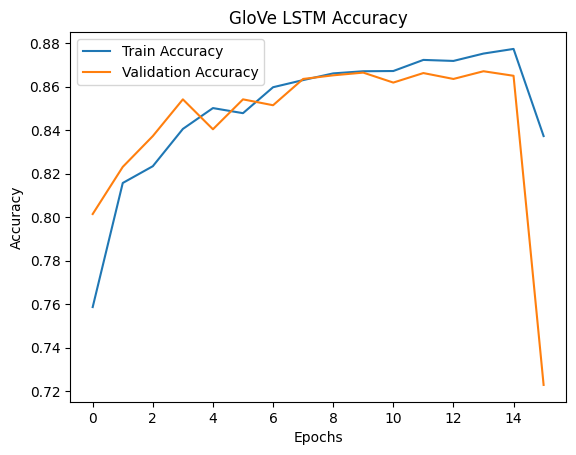

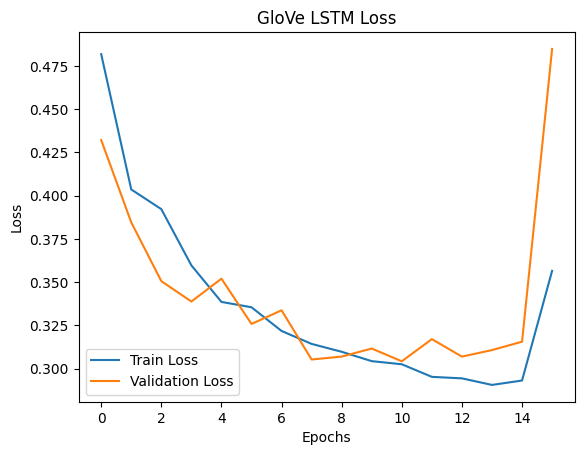

In [ ]:
# Accuracy
plt.plot(history_glove.history['accuracy'], label='Train Accuracy')
plt.plot(history_glove.history['val_accuracy'], label='Validation Accuracy')
plt.title('GloVe LSTM Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history_glove.history['loss'], label='Train Loss')
plt.plot(history_glove.history['val_loss'], label='Validation Loss')
plt.title('GloVe LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **Step 14: Evaluation – GloVe LSTM**

188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step
Confusion Matrix:
[[2612  431]
 [ 401 2556]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      3043
           1       0.86      0.86      0.86      2957

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



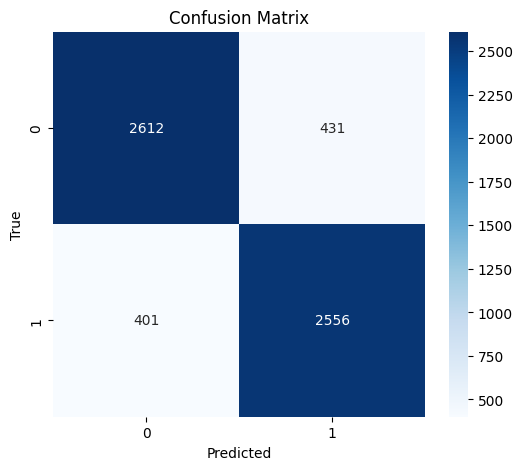

In [ ]:
y_pred_glove = (model_glove.predict(X_test) > 0.5).astype("int32")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_glove))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_glove))



cm = confusion_matrix(y_test, y_pred_glove)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Evaluation – GloVe Trainable (GRU)
y_pred_glove_trainable = (model_glove_trainable.predict(X_test) > 0.5).astype("int32")
print(" GloVe Trainable (GRU):")
print(classification_report(y_test, y_pred_glove_trainable))
print(confusion_matrix(y_test, y_pred_glove_trainable))


188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step
 GloVe Trainable (GRU):
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3043
           1       0.87      0.85      0.86      2957

    accuracy                           0.86      6000
   macro avg       0.87      0.86      0.86      6000
weighted avg       0.87      0.86      0.86      6000

[[2677  366]
 [ 445 2512]]


# **Step 15: Final Comparison of Both Models**

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Ensure y_true is 1D ints
y_true = y_test.ravel().astype("int32")

def predict_labels(m):
    # Keras -> (N,1) probs; convert to 1D int labels
    return (m.predict(X_test).ravel() > 0.5).astype("int32")

sections = [
    (" Custom Embedding LSTM:", model_custom, "y_pred_custom"),
    (" BiLSTM Custom:",         model_bilstm, "y_pred_bilstm"),
    (" GloVe LSTM (Frozen):",   model_glove,  "y_pred_glove"),
    (" GloVe Trainable (GRU):", model_glove_trainable, "y_pred_glove_trainable"),
]


for title, model, varname in sections:
    print(title)
    preds = predict_labels(model)
    globals()[varname] = preds
    print(classification_report(y_true, preds, digits=4))
    print(confusion_matrix(y_true, preds))


 Custom Embedding LSTM:
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step
              precision    recall  f1-score   support

           0     0.8467    0.8820    0.8640      3043
           1     0.8731    0.8356    0.8540      2957

    accuracy                         0.8592      6000
   macro avg     0.8599    0.8588    0.8590      6000
weighted avg     0.8597    0.8592    0.8591      6000

[[2684  359]
 [ 486 2471]]
 BiLSTM Custom:
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step
              precision    recall  f1-score   support

           0     0.8531    0.8991    0.8755      3043
           1     0.8901    0.8407    0.8647      2957

    accuracy                         0.8703      6000
   macro avg     0.8716    0.8699    0.8701      6000
weighted avg     0.8713    0.8703    0.8702      6000

[[2736  307]
 [ 471 2486]]
 GloVe LSTM (Frozen):
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step
              precision    recall  f1-score   support

           0     0.8669    0.8584    0.8626   

# **Final Comparison of Both Models with plots**

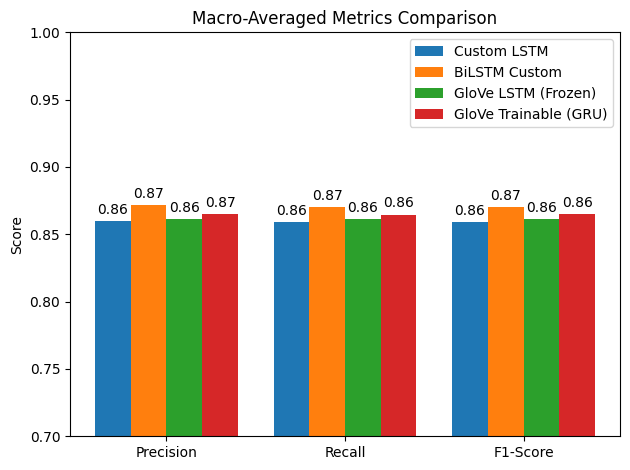

In [ ]:
# Generate reports as dictionaries (για τα 4 μοντέλα)
report_custom  = classification_report(y_test, y_pred_custom,           output_dict=True)
report_bilstm  = classification_report(y_test, y_pred_bilstm,           output_dict=True)
report_glove   = classification_report(y_test, y_pred_glove,            output_dict=True)
report_glove_t = classification_report(y_test, y_pred_glove_trainable,  output_dict=True)

# Extract macro avg metrics
labels = ['precision', 'recall', 'f1-score']
custom_scores  = [report_custom['macro avg'][metric] for metric in labels]
bilstm_scores  = [report_bilstm['macro avg'][metric] for metric in labels]
glove_scores   = [report_glove['macro avg'][metric] for metric in labels]
glove_t_scores = [report_glove_t['macro avg'][metric] for metric in labels]

# Plot with 4 bars per group
x = np.arange(len(labels))  # positions (0,1,2)
width = 0.2                 # width of each bar

fig, ax = plt.subplots()
bars1 = ax.bar(x - 1.5*width, custom_scores,  width, label='Custom LSTM')
bars2 = ax.bar(x - 0.5*width, bilstm_scores,  width, label='BiLSTM Custom')
bars3 = ax.bar(x + 0.5*width, glove_scores,   width, label='GloVe LSTM (Frozen)')
bars4 = ax.bar(x + 1.5*width, glove_t_scores, width, label='GloVe Trainable (GRU)')

# Labels, title, and formatting
ax.set_ylabel('Score')
ax.set_title('Macro-Averaged Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
ax.set_ylim([0.7, 1.0])
ax.legend()

# Annotate scores
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()
